# Space Mice Genes
## Heat Propagation and Clustering Package
### Python 3 compatible version

----------------------

Author: Mikayla Webster (13webstermj@gmail.com)

Date: 19th May, 2018

----------------------

<a id='toc'></a>
## Table of Contents
1. [Background](#background)
2. [Import packages](#import)
3. [Define Analysis Preferences](#pref)
3. [Load Networks](#load)
4. [Run Heat Propagation](#heat)
5. [Clustering](#cluster)

## Background
<a id='background'></a>

In [12]:
import sys
code_path = '../../network_bio_toolkit'
sys.path.append(code_path)

import importlib
import Heat3
importlib.reload(Heat3)

<module 'Heat3' from '../../network_bio_toolkit\\Heat3.py'>

In [13]:
symbol = 'symbol'
entrez = 'entrez'

human = 'human'
mouse = 'mouse'

heat = Heat3.Heat(gene_type = symbol, species = mouse)

In [14]:
#filename = '../../background_networks/10090.protein.links.v10.5.txt'
#heat.load_STRING_links(filename, confidence_filter = 700)

#print('\nNumber of interactions: ' + str(len(list(heat.DG_universe.edges()))))

In [15]:
#saved_DG_universe = heat.DG_universe
heat.DG_universe = saved_DG_universe

In [16]:
# load DEG file
DEG_filename = '../../DEG_databases/DE_CoeffspaceFlight - groundControl_glds48_20180312.csv'  
heat.create_DEG_list(DEG_filename, p_value_filter = 0.02, sep = ',')

print('Number of DEG\'s: ' + str(len(heat.DEG_list)))

Number of DEG's: 45


../../network_bio_toolkit\create_graph.py:366: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  df = pd.DataFrame.from_csv(filename, sep = sep)


## Localization 
<a id='local'></a>

C:\Users\m1web\Anaconda2\envs\ipykernel_py3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


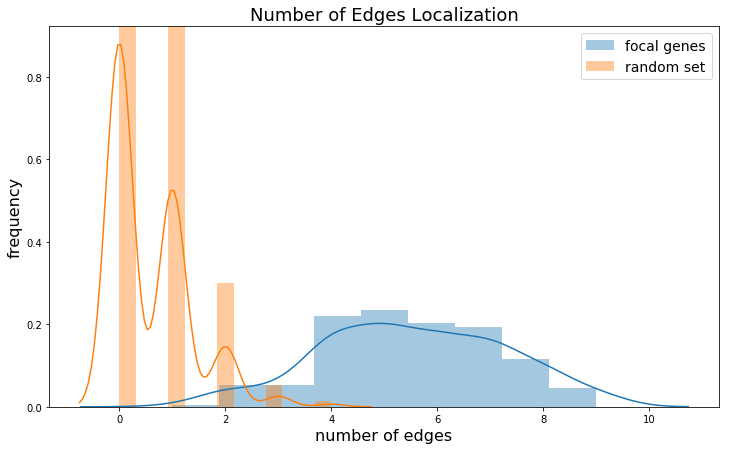

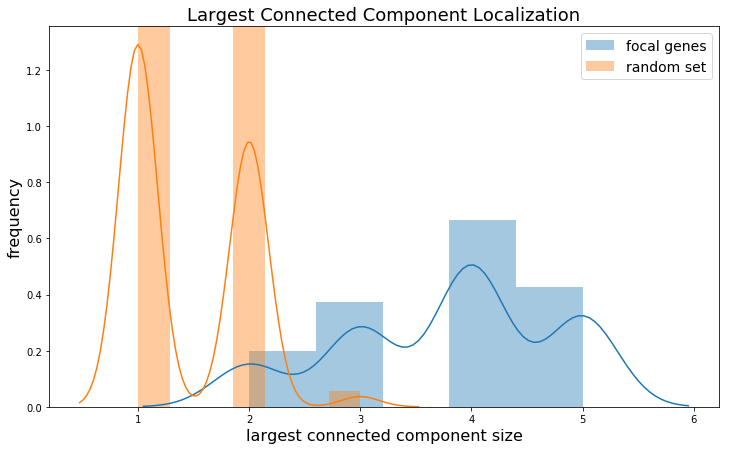

In [17]:
numedges_list, numedges_rand, LCC_list, LCC_rand = heat.localization(num_reps = 250, 
                                                                     sample_frac = 0.8, 
                                                                     method = 'both', 
                                                                     plot = True)

1.3828704847895779e-10


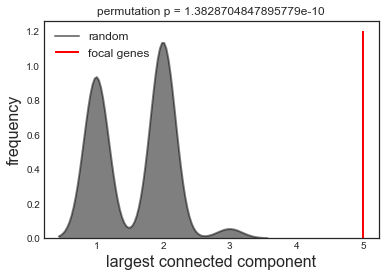

In [20]:
# test out plotting parameters with a smaller num_reps first.
numedges_list, numedges_rand, LCC_list, LCC_rand = heat.localization_full(num_reps = 200, 
                                                                          method = 'LCC', 
                                                                          label = 'focal genes',
                                                                          line_height = 1.2,
                                                                          legend_loc = 'upper left')

## Run Heat Propagation
<a id='heat'></a>

In [ ]:
heat.normalized_adj_matrix()

In [ ]:
saved_Wprime = heat.Wprime
heat.Wprime = saved_Wprime

In [ ]:
heat.draw_heat_prop(num_nodes = 500,
#                  random_walk = False,
                  edge_width = 2,
                  edge_smooth_enabled = True,
                  edge_smooth_type = 'bezier',
                  node_size_multiplier = 5,
                  hover = False,
                  hover_connected_edges = False,
                  largest_connected_component = True,
                  physics_enabled = True,
                  node_font_size = 40,
                  graph_id = 1,
                  node_shadow_x = 6)

## Clustering 
<a id='cluster'></a>

In [ ]:
heat.draw_clustering(rad_positions = False,
                k = None,
                largest_connected_component = True,
                num_top_genes = 500,
                cluster_size_cut_off = 5,
                remove_stray_nodes = True,
                node_spacing = 700,
                node_size_multiplier = 10,
                physics_enabled = True,
                node_font_size = 40,
                graph_id = 2,
                edge_width = 2,
                edge_smooth_enabled = True,
                edge_smooth_type = 'bezier',
                hover = False,
                hover_connected_edges = False
               )

In [ ]:
heat.cluster_legend(cluster_size_cut_off = 5)

In [ ]:
heat.draw_clustering(num_top_genes = 500,
                cluster_size_cut_off = 5,
                remove_stray_nodes = True,
                r = 0.4,
                node_spacing = 600,
                node_size_multiplier = 4,
                physics_enabled = False,
                node_font_size = 15,
                graph_id = 3,
                node_shadow_x = 6,
                largest_connected_component = True,
                color_lfc = True,
                vmin = -1,
                vmax = 1
               )

## Annotation
<a id='annotation'></a>

In [ ]:
heat.draw_clustering_with_annotation(graph_id = 4,
                        num_nodes = 500,
                        annotation = True,
                        node_spacing = 700,
                        node_size_multiplier = 5,
                        physics_enabled = False,
                        node_font_size = 20,
                        color_lfc = True,
                        vmin = -1,
                        vmax = 1,
                        node_size = 7)

In [ ]:
heat.draw_legend(vmin = -1, vmax = 1, label = 'log fold change')

In [ ]:
#heat.write_cluster_table('cluster_table_3.csv')